<a href="https://colab.research.google.com/github/sayakpaul/Adaptive-Gradient-Clipping/blob/main/AGC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates adaptive gradient clipping (AGC) as proposed in [High-Performance Large-Scale Image Recognition Without Normalization](https://arxiv.org/abs/2102.06171). For keeping it simple, I have used a MiniVGG style network architecture without any Batch Normalization layers. Results are demonstrated on the flowers dataset. 

One major difference in my implementation is that I clipped gradients of all the layers whereas in the original paper final linear layer wasn't clipped (refer to Section 4.1 of the original paper). 

## Initial setup

In [ ]:
!git clone https://github.com/sayakpaul/Adaptive-Gradient-Clipping

In [ ]:
import sys
sys.path.append("Adaptive-Gradient-Clipping")

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)
print(tf.__version__)

2.4.1


In [ ]:
try: # detect TPUs
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.44.200.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.44.200.242:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


In [ ]:
import agc
import dataloader
import models
import time
import utils

## Load flowers dataset

In [ ]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
train_filenames, valid_filenames, train_steps = dataloader.create_steps(batch_size=BATCH_SIZE, validation_split=0.15)
print(f"Total training samples: {dataloader.count_data_items(train_filenames)}")
print(f"Total validation samples: {dataloader.count_data_items(valid_filenames)}")
print(f"Global batch size: {BATCH_SIZE}")

Total training samples: 3220
Total validation samples: 450
Global batch size: 512


In [ ]:
train_ds = dataloader.get_training_dataset(batch_size=BATCH_SIZE, filenames=train_filenames)
validation_ds = dataloader.get_validation_dataset(batch_size=BATCH_SIZE, filenames=valid_filenames)
samples_images, sample_labels = next(iter(train_ds))
print(samples_images.shape, sample_labels.shape)

(512, 96, 96, 3) (512, 5)


## Encapsulate AGC logic inside `model.fit`

AGC is implemented as follows (taken from ther paper) - 
$$
G_{i}^{\ell} \rightarrow\left\{\begin{array}{ll}
\lambda \frac{\left\|W_{i}^{\ell}\right\|_{E}^{\star}}{\left\|G_{i}^{\ell}\right\|_{F}} G_{i}^{\ell} & \text { if } \frac{\left\|G_{i}^{\ell}\right\|_{F}}{\left\|W_{i}^{\ell}\right\|_{F}^{\star}}>\lambda \\
G_{i}^{\ell} & \text { otherwise }
\end{array}\right.
$$

where, $\left\|W_{i}\right\|_{F}^{\star}=\max \left(\left\|W_{i}\right\|_{F}, \epsilon\right)$ and $\epsilon$ defaults to 1e-3.  

In [ ]:
class AGCModel(tf.keras.Model):
    def __init__(self, mini_vgg, clip_factor=0.01, eps=1e-3):
        super(AGCModel, self).__init__()
        self.mini_vgg = mini_vgg
        self.clip_factor = clip_factor
        self.eps = eps
    
    def train_step(self, data):
        images, labels = data

        with tf.GradientTape() as tape:
            predictions = self.mini_vgg(images)
            loss = self.compiled_loss(labels, predictions)
        trainable_params = self.mini_vgg.trainable_variables
        gradients = tape.gradient(loss, trainable_params)
        agc_gradients = agc.adaptive_clip_grad(trainable_params, gradients, 
                                               clip_factor=self.clip_factor, eps=self.eps)
        self.optimizer.apply_gradients(zip(agc_gradients, trainable_params))

        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        images, labels = data
        predictions = self.mini_vgg(images, training=False)
        loss = self.compiled_loss(labels, predictions)
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def save_weights(self, filepath):
        self.mini_vgg.save_weights(filepath=filepath)

    def call(self, inputs, *args, **kwargs):
        return self.mini_vgg(inputs)

**Note**: `clip_factor` can have been tuned but as per the figure below, for a batch size of 512, `clip_factor=0.01` should be good as a baseline - 

<center>
<img src="https://i.ibb.co/wc1qpmt/image.png"></img><br>
<smal>Source: Original Paper</small>
</center>

## Compile model and define training callbacks

In [ ]:
with strategy.scope():
    model = AGCModel(models.get_mini_vgg(use_bn=False))

model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
print(f"Total learnable parameters: {model.mini_vgg.count_params()/1e6} M")

Total learnable parameters: 0.002117 M


In [ ]:
train_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5,
        patience=3, verbose=1
    )
]

## Model training and evaluation

In [ ]:
start = time.time()
history = model.fit(train_ds,
                   steps_per_epoch=train_steps,
                   validation_data=validation_ds,
                   callbacks=train_callbacks,
                   epochs=100)
print(f"Total training time: {(time.time() - start)/60.} minutes")

Epoch 1/100
6/6 [==============================] - 8s 837ms/step - loss: 1.7070 - accuracy: 0.2338 - val_loss: 1.6397 - val_accuracy: 0.2733
Epoch 2/100
6/6 [==============================] - 1s 253ms/step - loss: 1.6289 - accuracy: 0.2337 - val_loss: 1.5997 - val_accuracy: 0.2467
Epoch 3/100
6/6 [==============================] - 2s 301ms/step - loss: 1.5999 - accuracy: 0.2408 - val_loss: 1.5847 - val_accuracy: 0.2711
Epoch 4/100
6/6 [==============================] - 1s 276ms/step - loss: 1.5835 - accuracy: 0.2838 - val_loss: 1.5716 - val_accuracy: 0.3022
Epoch 5/100
6/6 [==============================] - 2s 325ms/step - loss: 1.5762 - accuracy: 0.2916 - val_loss: 1.5565 - val_accuracy: 0.3222
Epoch 6/100
6/6 [==============================] - 2s 274ms/step - loss: 1.5643 - accuracy: 0.2945 - val_loss: 1.5464 - val_accuracy: 0.3511
Epoch 7/100
6/6 [==============================] - 1s 277ms/step - loss: 1.5487 - accuracy: 0.3215 - val_loss: 1.5336 - val_accuracy: 0.3800
Epoch 8/100
6

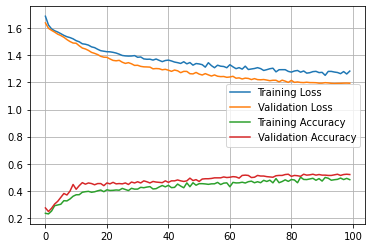

1/1 [==============================] - 1s 1s/step - loss: 1.1943 - accuracy: 0.5200
Validation accuracy: 52.00%


In [ ]:
utils.plot_history(history)
_, accuracy = model.evaluate(validation_ds)
print("Validation accuracy: {:.2f}%".format(accuracy*100))

Kindly keep in mind that the network is relatively very shallow.